# HerdNet Model Prediction

This notebook loads a trained HerdNet model and performs predictions on individual images, visualizing the results with matplotlib.

## Setup

In [28]:
import sys
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from animaloc.models import HerdNet
from animaloc.data.transforms import DownSample
from animaloc.utils.seed import set_seed
from animaloc.eval import HerdNetStitcher

# Set seed for reproducibility
set_seed(1)

# Set matplotlib backend for notebooks
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Configuration

In [29]:
# Model configuration (matching training config)
num_classes = 7
down_ratio = 2
patch_size = 512

# Find the latest model
output_dirs = glob.glob('/home/lmanrique/Do/HerdNet/outputs/2025-09-13/*/')
output_dirs.sort(key=lambda x: os.path.basename(x.rstrip('/')))
latest_dir = output_dirs[-1]

# Look for best_model.pth, fallback to latest_model.pth
best_model_path = os.path.join(latest_dir, 'best_model.pth')
latest_model_path = os.path.join(latest_dir, 'latest_model.pth')

if os.path.exists(best_model_path):
    model_path = best_model_path
    print(f"Using best model: {model_path}")
elif os.path.exists(latest_model_path):
    model_path = latest_model_path
    print(f"Using latest model: {model_path}")
else:
    raise FileNotFoundError(f"No model found in {latest_dir}")

# Class names for visualization
class_names = ['background', 'topi', 'buffalo', 'kob', 'warthog', 'waterbuck', 'elephant']
class_colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'brown']

# Test image path - modify this to point to your image
test_image_path = '/home/lmanrique/Do/HerdNet/data/test'  # Directory with test images

print(f"Model path: {model_path}")
print(f"Test images directory: {test_image_path}")

Using latest model: /home/lmanrique/Do/HerdNet/outputs/2025-09-13/22-52-06/latest_model.pth
Model path: /home/lmanrique/Do/HerdNet/outputs/2025-09-13/22-52-06/latest_model.pth
Test images directory: /home/lmanrique/Do/HerdNet/data/test


## Load Model

In [30]:
# Initialize HerdNet model
herdnet = HerdNet(
    num_classes=num_classes,
    down_ratio=down_ratio,
    num_layers=34,
    pretrained=False,  # Set to False since we're loading trained weights
    head_conv=64
).cuda()

# Load trained model weights with custom handling for LossWrapper
checkpoint = torch.load(model_path, map_location='cuda')

# Check if the model was saved with LossWrapper (keys prefixed with 'model.')
if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
else:
    state_dict = checkpoint

# Remove 'model.' prefix if present
if any(key.startswith('model.') for key in state_dict.keys()):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith('model.'):
            new_key = key[6:]  # Remove 'model.' prefix
            new_state_dict[new_key] = value
        else:
            new_state_dict[key] = value
    state_dict = new_state_dict

# Load the corrected state dict
herdnet.load_state_dict(state_dict, strict=False)  # Use strict=False to handle minor mismatches
herdnet.eval()  # Set to evaluation mode

print(f"Model loaded successfully from {model_path}")
print(f"Model is on device: {next(herdnet.parameters()).device}")

Model loaded successfully from /home/lmanrique/Do/HerdNet/outputs/2025-09-13/22-52-06/latest_model.pth
Model is on device: cuda:0


## Helper Functions

In [38]:
def load_and_preprocess_image(image_path, target_size=512):
    """
    Load and preprocess an image for model inference.
    """
    # Load image
    image = Image.open(image_path).convert('RGB')
    original_size = image.size  # (width, height)
    
    # Convert to numpy array
    image_np = np.array(image)
    
    # Define preprocessing transforms
    transform = A.Compose([
        A.Resize(height=target_size, width=target_size, p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2()
    ])
    
    # Apply transforms
    transformed = transform(image=image_np)
    processed_image = transformed['image'].unsqueeze(0)  # Add batch dimension
    
    return processed_image, image_np, original_size

def extract_detections_from_heatmap(heatmap, threshold=0.5, down_ratio=2):
    """
    Extract point detections from class heatmaps.
    """
    detections = []
    
    # Process each class (skip background class 0)
    for class_id in range(1, heatmap.shape[0]):
        class_heatmap = heatmap[class_id]
        
        # Find peaks above threshold
        peaks = (class_heatmap > threshold).nonzero(as_tuple=False)
        
        for peak in peaks:
            y, x = peak[0].item(), peak[1].item()
            confidence = class_heatmap[y, x].item()
            
            # Convert back to original coordinates
            x_orig = x * down_ratio
            y_orig = y * down_ratio
            
            detections.append({
                'x': x_orig,
                'y': y_orig,
                'class_id': class_id,
                'class_name': class_names[class_id],
                'confidence': confidence
            })
    
    return detections

def visualize_predictions(image, detections, target_size=512, title="Predictions"):
    """
    Visualize predictions on the resized image (same size as training).
    """
    # Resize image to match training size for consistent visualization
    resized_image = np.array(Image.fromarray(image).resize((target_size, target_size)))
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Display resized image (same size as training)
    ax.imshow(resized_image)
    ax.set_title(f"{title} - {len(detections)} detections found", fontsize=14, fontweight='bold')
    
    # Plot detections (coordinates are already in the correct scale)
    for det in detections:
        x = det['x']
        y = det['y']
        
        class_id = det['class_id']
        color = class_colors[class_id]

        print(f"Detection: {det['class_name']} at ({x}, {y}) with confidence {det['confidence']:.2f}")
        
        # Draw circle for detection
        circle = patches.Circle((x, y), radius=8, 
                              linewidth=2, edgecolor=color, 
                              facecolor='none', alpha=0.8)
        ax.add_patch(circle)
        
        # Add label
        ax.text(x + 10, y - 10, 
               f"{det['class_name']}\n{det['confidence']:.2f}", 
               fontsize=8, color=color, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print detection summary
    print(f"\nDetection Summary:")
    class_counts = {}
    for det in detections:
        class_name = det['class_name']
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count}")
    print(f"  Total: {len(detections)}")

## Select and Load Test Image

In [39]:
# Get list of available test images
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
available_images = []

for ext in image_extensions:
    available_images.extend(glob.glob(os.path.join(test_image_path, ext)))
    available_images.extend(glob.glob(os.path.join(test_image_path, ext.upper())))

if not available_images:
    print(f"No images found in {test_image_path}")
    print("Please update the test_image_path variable to point to a directory with images.")
else:
    print(f"Found {len(available_images)} images in {test_image_path}")
    
    # Show first few available images
    print("\nFirst 5 available images:")
    for i, img_path in enumerate(available_images[:5]):
        print(f"  {i}: {os.path.basename(img_path)}")
    
    # Select the first image for demonstration (you can change this)
    selected_image_path = available_images[0]
    print(f"\nSelected image: {os.path.basename(selected_image_path)}")

Found 258 images in /home/lmanrique/Do/HerdNet/data/test

First 5 available images:
  0: S_07_05_16_DSC00415.JPG
  1: S_07_05_16_DSC00436.JPG
  2: S_07_05_16_DSC00421.JPG
  3: S_07_05_16_DSC00416.JPG
  4: S_07_05_16_DSC00423.JPG

Selected image: S_07_05_16_DSC00415.JPG


## Run Prediction

In [40]:
# Load and preprocess the selected image
if 'selected_image_path' in locals():
    processed_image, original_image, original_size = load_and_preprocess_image(selected_image_path, patch_size)
    
    print(f"Original image size: {original_size}")
    print(f"Processed image shape: {processed_image.shape}")
    
    # Move to GPU
    processed_image = processed_image.cuda()
    
    # Run inference
    with torch.no_grad():
        # Get model predictions
        output = herdnet(processed_image)
        
        # Handle different output formats
        if isinstance(output, (list, tuple)):
            # If model returns multiple outputs, use the second one (class heatmaps)
            if len(output) >= 2:
                class_heatmaps = output[1]  # Shape: [batch, num_classes, H, W]
            else:
                class_heatmaps = output[0]
        else:
            class_heatmaps = output
        
        # Remove batch dimension and move to CPU
        class_heatmaps = class_heatmaps.squeeze(0).cpu()
        
        print(f"Model output shape: {class_heatmaps.shape}")
        
        # Apply softmax to get probabilities
        class_probs = torch.softmax(class_heatmaps, dim=0)
        
        # Extract detections from heatmaps
        detections = extract_detections_from_heatmap(class_probs, threshold=0.3, down_ratio=down_ratio)
        
        print(f"\nFound {len(detections)} detections with confidence > 0.3")
        
else:
    print("No image selected. Please check the test_image_path and run the previous cell.")

Original image size: (6000, 4000)
Processed image shape: torch.Size([1, 3, 512, 512])
Model output shape: torch.Size([7, 16, 16])

Found 82 detections with confidence > 0.3


## Visualize Results

Detection: kob at (14, 0) with confidence 0.83
Detection: kob at (16, 0) with confidence 1.00
Detection: kob at (18, 0) with confidence 1.00
Detection: kob at (20, 0) with confidence 1.00
Detection: kob at (22, 0) with confidence 0.99
Detection: kob at (14, 2) with confidence 0.97
Detection: kob at (16, 2) with confidence 1.00
Detection: kob at (18, 2) with confidence 1.00
Detection: kob at (20, 2) with confidence 1.00
Detection: kob at (22, 2) with confidence 1.00
Detection: kob at (14, 4) with confidence 0.87
Detection: kob at (16, 4) with confidence 1.00
Detection: kob at (18, 4) with confidence 1.00
Detection: kob at (20, 4) with confidence 1.00
Detection: kob at (22, 4) with confidence 1.00
Detection: kob at (24, 4) with confidence 1.00
Detection: kob at (14, 6) with confidence 0.80
Detection: kob at (16, 6) with confidence 1.00
Detection: kob at (18, 6) with confidence 1.00
Detection: kob at (20, 6) with confidence 1.00
Detection: kob at (22, 6) with confidence 1.00
Detection: ko

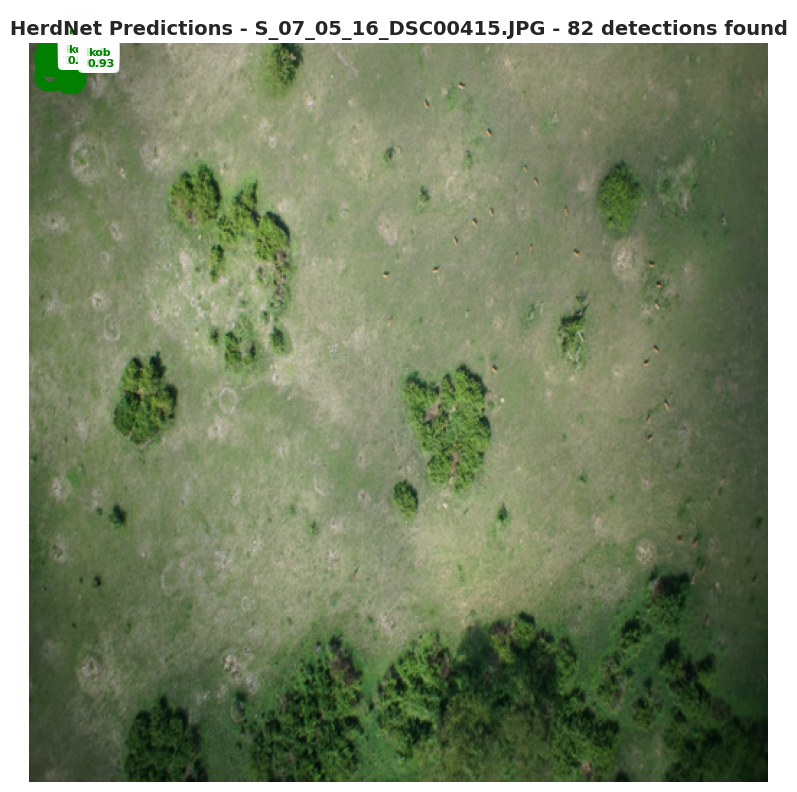


Detection Summary:
  kob: 82
  Total: 82


In [41]:
# Visualize the predictions
if 'detections' in locals() and 'original_image' in locals():
    visualize_predictions(
        original_image, 
        detections, 
        target_size=patch_size,
        title=f"HerdNet Predictions - {os.path.basename(selected_image_path)}"
    )
else:
    print("No predictions to visualize. Please run the prediction cell first.")

## Visualize Class Heatmaps

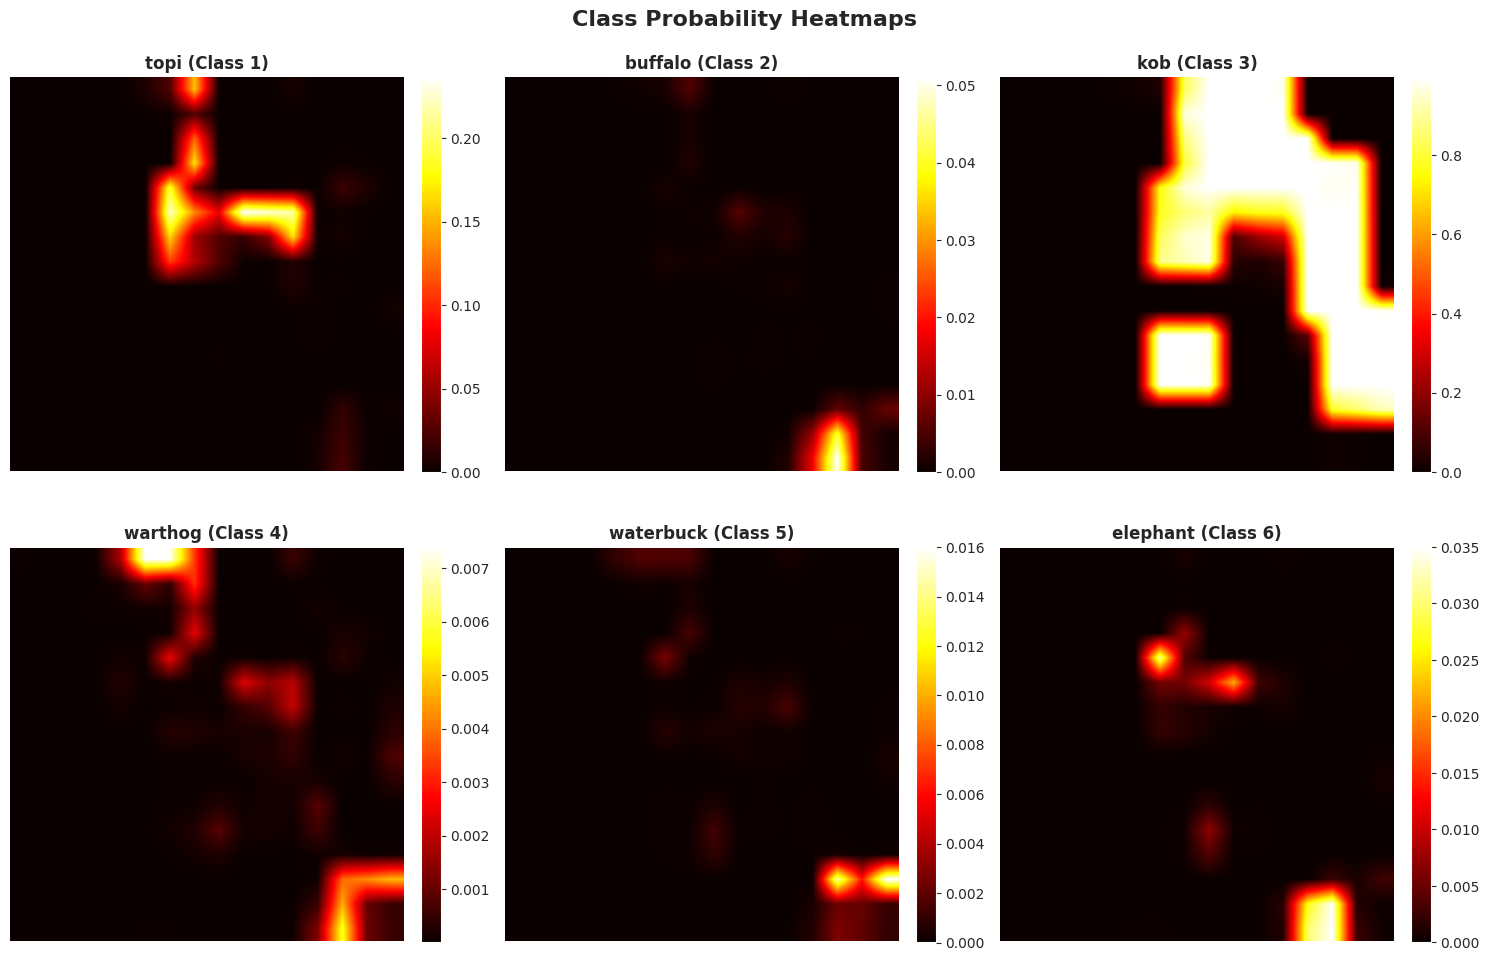

In [35]:
# Visualize individual class heatmaps
if 'class_probs' in locals():
    # Create subplot for each class
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Plot heatmap for each class (skip background)
    for i in range(1, min(num_classes, 7)):
        if i-1 < len(axes):
            heatmap = class_probs[i].numpy()
            im = axes[i-1].imshow(heatmap, cmap='hot', interpolation='bilinear')
            axes[i-1].set_title(f'{class_names[i]} (Class {i})', fontweight='bold')
            axes[i-1].axis('off')
            plt.colorbar(im, ax=axes[i-1], fraction=0.046, pad=0.04)
    
    # Hide unused subplots
    for i in range(num_classes-1, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Class Probability Heatmaps', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No heatmaps to visualize. Please run the prediction cell first.")

## Interactive Image Selection

Predicting on second image with threshold 0.4:
Processing: S_07_05_16_DSC00436.JPG


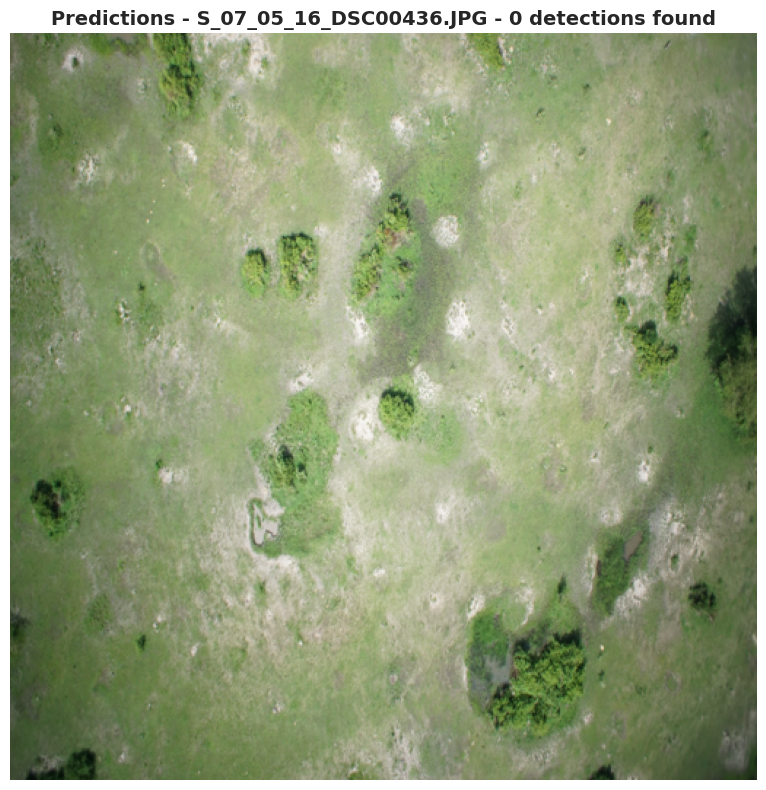


Detection Summary:
  Total: 0


In [36]:
# Function to predict on a specific image by index
def predict_image_by_index(image_index, threshold=0.3):
    """
    Predict on an image by its index in the available_images list.
    """
    if image_index >= len(available_images):
        print(f"Index {image_index} out of range. Available images: 0-{len(available_images)-1}")
        return
    
    selected_path = available_images[image_index]
    print(f"Processing: {os.path.basename(selected_path)}")
    
    # Load and preprocess
    processed_img, orig_img, orig_size = load_and_preprocess_image(selected_path, patch_size)
    processed_img = processed_img.cuda()
    
    # Predict
    with torch.no_grad():
        output = herdnet(processed_img)
        
        if isinstance(output, (list, tuple)):
            if len(output) >= 2:
                heatmaps = output[1]
            else:
                heatmaps = output[0]
        else:
            heatmaps = output
        
        heatmaps = heatmaps.squeeze(0).cpu()
        probs = torch.softmax(heatmaps, dim=0)
        dets = extract_detections_from_heatmap(probs, threshold=threshold, down_ratio=down_ratio)
    
    # Visualize
    visualize_predictions(
        orig_img, 
        dets, 
        target_size=patch_size,
        title=f"Predictions - {os.path.basename(selected_path)}"
    )
    
    return dets, probs

# Example: predict on the second image (index 1) with threshold 0.4
if len(available_images) > 1:
    print("Predicting on second image with threshold 0.4:")
    detections_2, heatmaps_2 = predict_image_by_index(1, threshold=0.4)
else:
    print("Only one image available. Try adding more images to the test directory.")

## Threshold Analysis

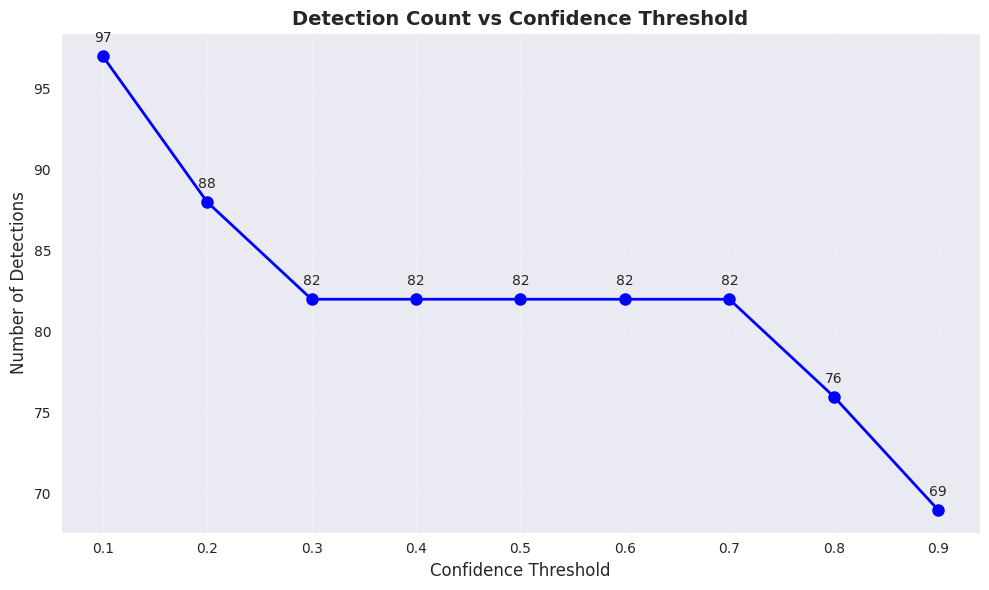


Detection counts at different thresholds:
  Threshold 0.1: 97 detections
  Threshold 0.2: 88 detections
  Threshold 0.3: 82 detections
  Threshold 0.4: 82 detections
  Threshold 0.5: 82 detections
  Threshold 0.6: 82 detections
  Threshold 0.7: 82 detections
  Threshold 0.8: 76 detections
  Threshold 0.9: 69 detections


In [37]:
# Analyze detection counts at different thresholds
if 'class_probs' in locals():
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    detection_counts = []
    
    for thresh in thresholds:
        dets = extract_detections_from_heatmap(class_probs, threshold=thresh, down_ratio=down_ratio)
        detection_counts.append(len(dets))
    
    # Plot threshold vs detection count
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, detection_counts, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Confidence Threshold', fontsize=12)
    plt.ylabel('Number of Detections', fontsize=12)
    plt.title('Detection Count vs Confidence Threshold', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(thresholds)
    
    # Add value labels on points
    for i, (thresh, count) in enumerate(zip(thresholds, detection_counts)):
        plt.annotate(str(count), (thresh, count), 
                    textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\nDetection counts at different thresholds:")
    for thresh, count in zip(thresholds, detection_counts):
        print(f"  Threshold {thresh:.1f}: {count} detections")
else:
    print("No predictions available for threshold analysis.")